# IMPORT PAKET YANG DIBUTUHKAN

In [1]:
#Perpustakaan Tensorflow. Digunakan untuk mengimplementasikan model pembelajaran mesin
import tensorflow as tf
#Pustaka gambar untuk manipulasi gambar
from PIL import Image
#Numpy berisi fungsi yang bermanfaat untuk perhitungan matematika yang efisien
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
#Utils file
import imutils
import pickle
import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Activation, ReLU, Input, Dropout, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
import os

# DATASET

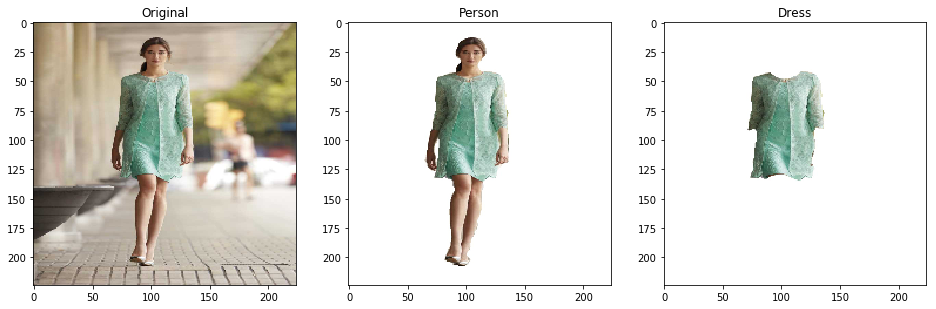

In [2]:
### PLOT SATU SAMPEL GAMBAR DALAM DATA ###
original = cv.imread('./original77.jpg')
original = cv.resize(original,(224,224))
dress = cv.imread('./dress77.jpg')
dress = cv.resize(dress,(224,224))
body = cv.imread('./body77.jpg')
body = cv.resize(body,(224,224))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(cv.cvtColor(original, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,2)
plt.title('Person')
plt.imshow(cv.cvtColor(body, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,3)
plt.title('Dress')
plt.imshow(cv.cvtColor(dress, cv.COLOR_BGRA2RGB))

# PREPARE IMAGES FOR SEGMENTATION

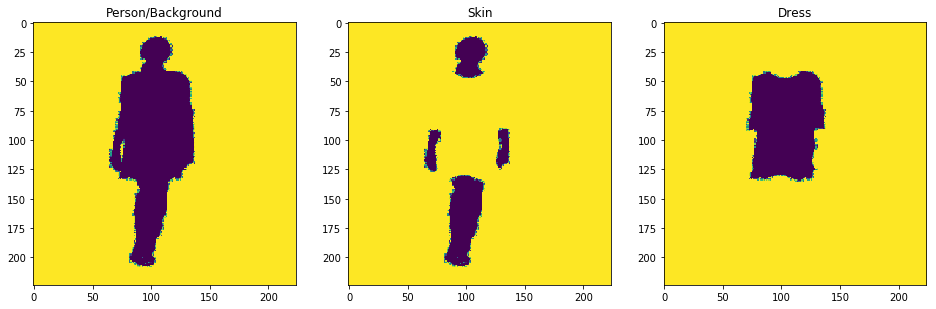

In [3]:
dress = cv.imread('./dress77.jpg',0)
body = cv.imread('./body77.jpg',0)

### ENCODE DRESS ###
dress[dress == 255] = 0
dress[dress > 0] = 255
dress = cv.resize(dress,(224,224))

### ENCODE BODY ###
body[body == 255] = 0
body[body > 0] = 255
body = cv.resize(body,(224,224))

### ENCODE SKIN ###
skin = body - dress


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Person/Background')
bg = (255 - body)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Skin')
skin = (255 - skin)/255
plt.imshow(skin)
plt.subplot(1,3,3)
plt.title('Dress')
dress = (255 - dress)/255
plt.imshow(dress)

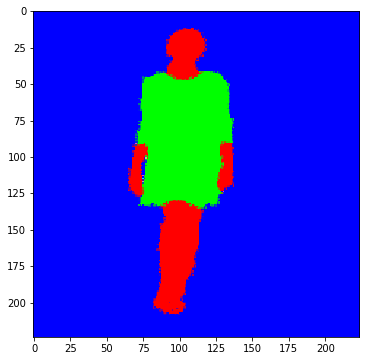

In [4]:
### COMBINE BACKGROUND, SKIN, DRESS ###
gt = np.zeros((224,224,3))
gt[:,:,0] = (1-skin)
gt[:,:,1] = (1-dress)
gt[:,:,2] = bg

plt.figure(figsize=(6,6))
plt.imshow(gt)

In [16]:
### ENCODE BACKGROUND, SKIN, DRESS FOR ALL TRAIN IMAGES ###

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 81

for i in tqdm.tqdm(range(1,n_img+1)):
    
    original = cv.imread('./original77.jpg')
    original = cv.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]
    
    body = cv.imread('./body77.jpg',0)
    dress = cv.imread('./dress77.jpg',0)
    
    dress[dress == 255] = 0
    dress[dress > 0] = 255
    dress = cv.resize(dress,(224,224))

    body[body == 255] = 0
    body[body > 0] = 255
    body = cv.resize(body,(224,224))

    skin = body - dress
    bg = (255 - body)/255
    skin = (255 - skin)/255
    dress = (255 - dress)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-skin)
    gt[:,:,1] = (1-dress)
    gt[:,:,2] = bg
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.astype('int')

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:03<00:00, 24.64it/s]


In [17]:
pickle.dump(mean, open("./mean81.pkl", "wb"))

# TRAIN UNET

In [10]:
def custom_activation(x):
    return K.relu(x, alpha=0.0, max_value=1)


def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

smooth = 1.

In [11]:
def get_unet(do=0, activation=ReLU):
  
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['accuracy'])

    return model

In [12]:
x_raw = np.asarray(images_original) - mean.reshape(-1,224,224,3) 
x_gt = np.asarray(images_gt).reshape(-1,224,224,3) 

In [13]:
model = get_unet()
model.summary()

W0811 02:08:27.419685  9420 deprecation.py:506] From C:\Users\ADMIN\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 02:08:28.914006  9420 deprecation.py:323] From C:\Users\ADMIN\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, None, None, 3 0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, None, 3 0           re_lu[0][0]                      
______________________________________________________________________________________________

In [14]:
history = model.fit(x_raw, x_gt, epochs=120)

Epoch 1/120
81/81 [==============================] - ETA: 1:59 - loss: 0.6931 - acc: 0.661 - ETA: 40s - loss: 0.6930 - acc: 0.774 - 205s 3s/sample - loss: 0.6928 - acc: 0.7982
Epoch 2/120
81/81 [==============================] - ETA: 2:02 - loss: 0.6920 - acc: 0.887 - ETA: 40s - loss: 0.6918 - acc: 0.887 - 193s 2s/sample - loss: 0.6917 - acc: 0.8876
Epoch 3/120
81/81 [==============================] - ETA: 1:55 - loss: 0.6908 - acc: 0.887 - ETA: 39s - loss: 0.6906 - acc: 0.887 - 192s 2s/sample - loss: 0.6905 - acc: 0.8876
Epoch 4/120
81/81 [==============================] - ETA: 1:51 - loss: 0.6896 - acc: 0.887 - ETA: 39s - loss: 0.6894 - acc: 0.887 - 185s 2s/sample - loss: 0.6893 - acc: 0.8876
Epoch 5/120
81/81 [==============================] - ETA: 1:55 - loss: 0.6884 - acc: 0.887 - ETA: 39s - loss: 0.6883 - acc: 0.887 - 188s 2s/sample - loss: 0.6881 - acc: 0.8876
Epoch 6/120
81/81 [==============================] - ETA: 1:51 - loss: 0.6873 - acc: 0.887 - ETA: 38s - loss: 0.6871 - a

81/81 [==============================] - ETA: 1:52 - loss: 0.5976 - acc: 0.887 - ETA: 40s - loss: 0.5975 - acc: 0.887 - 195s 2s/sample - loss: 0.5974 - acc: 0.8876
Epoch 94/120
81/81 [==============================] - ETA: 1:55 - loss: 0.5967 - acc: 0.887 - ETA: 41s - loss: 0.5966 - acc: 0.887 - 205s 3s/sample - loss: 0.5965 - acc: 0.8876
Epoch 95/120
81/81 [==============================] - ETA: 1:54 - loss: 0.5958 - acc: 0.887 - ETA: 40s - loss: 0.5957 - acc: 0.887 - 191s 2s/sample - loss: 0.5956 - acc: 0.8876
Epoch 96/120
81/81 [==============================] - ETA: 1:54 - loss: 0.5949 - acc: 0.887 - ETA: 39s - loss: 0.5948 - acc: 0.887 - 187s 2s/sample - loss: 0.5947 - acc: 0.8876
Epoch 97/120
81/81 [==============================] - ETA: 1:49 - loss: 0.5940 - acc: 0.887 - ETA: 38s - loss: 0.5939 - acc: 0.887 - 191s 2s/sample - loss: 0.5938 - acc: 0.8876
Epoch 98/120
81/81 [==============================] - ETA: 1:55 - loss: 0.5931 - acc: 0.887 - ETA: 41s - loss: 0.5930 - acc: 0.8

In [15]:
model.save('./fashion_unet.h5')

silahkan melanjutkan di extract dress